Как водится в продакшен-реди решениях на тензорфлоу надо перезапустить среду каждый раз после установки нового пакета - это не ошибка.

In [2]:
#!pip install --upgrade numpy tensorflow

## **Load the required libraries**

In [3]:
#!pip install sionna

In [4]:
# You may install the required libraries from https://nvlabs.github.io/sionna/installation.html
# or generate channel here in google colab
# ---------------------------------------------------------------------------------------------
# Load the required libraries
import numpy as np
import matplotlib.pyplot as plt

try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
from sionna.phy.channel.tr38901 import Antenna, AntennaArray, UMa, UMi, RMa
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, gen_single_sector_topology
from sionna.phy.ofdm import ResourceGrid

## **Configiration parameters**

In [5]:
# ===========================
# 1️⃣ Define BS & UE Parameters
# ===========================
num_bs = 1  # Number of Base Stations
num_ue = 20  # Number of User Equipments   уменьшила до 20
num_ue_ant = 4  # UE MIMO Antennas
batch_size = 20  # Number of parallel simulations   уменьшила до 4
scenario = "UMa"  # Urban Macro (Can be "UMa", "UMi", "RMa")
min_bs_ut_dist = 100 # Minimum BS-UE distance in meters
ISD = 500 # Inter-Site Distance
bs_height = 25 # BS height in meters
ut_height = 1.5 # UE height in meters
UE_speed = 0.83 # UE speed in meters/second

# ===========================
# 2️⃣ Define Resource Grid
# ===========================
carrier_frequency = 3.5e9  # 2.14 or 3.5 GHz (mid-band 5G)
fft_size = 256  # FFT Size   уменьшила до 256
sc_spacing = 30e3  # Subcarrier Spacing (30 kHz for FR1)
num_ofdm_symbols = 1  # OFDM symbols per slot

# ===========================
# 3️⃣ Define Antenna Array Configurations
# ===========================
bs_array = AntennaArray(
    num_rows=4, # number of rows in BS antenna array
    num_cols=8, # number of columns in BS antenna array
    polarization="dual", # "single" or "dual"
    polarization_type="cross", # for single polarization, must be "V" or "H". For dual polarization, must be "VH" or "cross"
    antenna_pattern="38.901", # "omni" or "38.901"
    carrier_frequency=carrier_frequency,
    vertical_spacing=0.9, # 0.9-wavelength spacing between vertical antenna elements
    horizontal_spacing=0.5 # Half-wavelength spacing between horizontal antenna elements
)

ue_array = AntennaArray(
    num_rows=1, # number of rows in UE antenna array
    num_cols=2, # number of columns in UE antenna array
    polarization="dual", # "single" or "dual"
    polarization_type="cross", # for single polarization, must be "V" or "H". For dual polarization, must be "VH" or "cross"
    antenna_pattern="38.901", # "omni" or "38.901"
    carrier_frequency=carrier_frequency,
    vertical_spacing=1, # One-wavelength spacing between vertical antenna elements
    horizontal_spacing=1  # One-wavelength spacing between horizontal antenna elements
)

# ===========================
# 4️⃣ Select Channel Model
# ===========================
if scenario == "UMa":
  channel_model = UMa(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")
elif scenario == "UMi":
  channel_model = UMi(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")
elif scenario == "RMa":
  channel_model = RMa(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")

# ===========================
# 5️⃣ Set 3GPP Scenario Parameters
# ===========================
pre_topology = sionna.phy.channel.set_3gpp_scenario_parameters(
                      scenario=scenario.lower(),
                      min_bs_ut_dist=min_bs_ut_dist,  # Minimum BS-UE distance in meters
                      isd=ISD,  # Inter-Site Distance
                      bs_height=bs_height,  # BS height in meters
                      min_ut_height=ut_height,  # Minimum UE height in meters
                      max_ut_height=ut_height,  # Maximum UE height in meters
                      indoor_probability=0, # Probability of a UE to be indoor
                      min_ut_velocity=UE_speed, # ! meter/sec
                      max_ut_velocity=UE_speed)

min_bs_ut_dist, isd, bs_height, min_ut_height, max_ut_height, indoor_probability, min_ut_velocity, max_ut_velocity = pre_topology

## **Channel generation**

-----------------------------------------------------
Size of output frequency domain channel tensor:
 batch_size = 20 
 UE number = 20 
 UE antenna number = 4 
 BS number = 1 
 BS antenna number = 64 
 number ofdm symbols = 1 
 Subcarriers number = 256
*********** Successful channel generation ***********


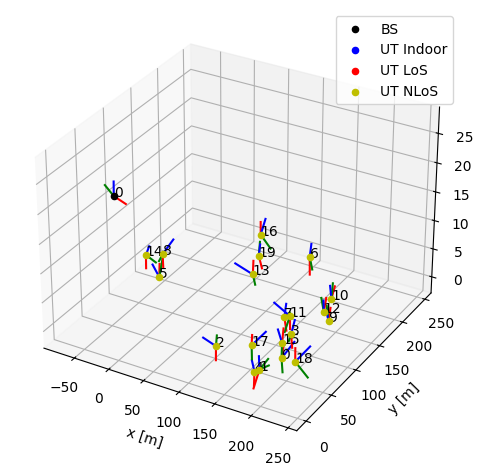

In [6]:
# ===========================
# 6️⃣ Generate Single Sector Topology
# ===========================
topology = gen_single_sector_topology(
                      batch_size=batch_size,
                      num_ut=num_ue,
                      isd=isd,
                      min_bs_ut_dist=min_bs_ut_dist,
                      scenario=scenario.lower(),
                      min_ut_height=min_ut_height,
                      max_ut_height=max_ut_height,
                      indoor_probability=indoor_probability,
                      min_ut_velocity=min_ut_velocity,
                      max_ut_velocity=max_ut_velocity)

ut_loc, bs_loc, ut_orientations, bs_orientations, ut_velocities, in_state = topology

# ===========================
# 7️⃣ Set Topology into the Channel Model
# ===========================
channel_model.set_topology(
    ut_loc,
    bs_loc,
    ut_orientations,
    bs_orientations,
    ut_velocities,
    in_state,
    los = False)# los=False=NLoS, los=True=LoS, None=LoS

channel_model.show_topology()

# ===========================
# 8️⃣ Simulate Time-Domain Channel
# ===========================
a, tau = channel_model(num_time_samples=num_ofdm_symbols,sampling_frequency=sc_spacing)  # Get channel impulse response (CIR)

# ===========================
# 9️⃣ Move Channel from Time to Frequency Domain
# ===========================
subcarrier_freqs = subcarrier_frequencies(fft_size, sc_spacing)
H_freq = cir_to_ofdm_channel(subcarrier_freqs, a, tau, normalize=True)  # Convert CIR to OFDM channel

print("-----------------------------------------------------")
print(f"Size of output frequency domain channel tensor:\n batch_size = {H_freq.shape[0]} \n UE number = {H_freq.shape[1]} \n UE antenna number = {H_freq.shape[2]} \n BS number = {H_freq.shape[3]} \n BS antenna number = {H_freq.shape[4]} \n number ofdm symbols = {H_freq.shape[5]} \n Subcarriers number = {H_freq.shape[6]}")
print("*********** Successful channel generation ***********")

# ===========================
# ✅ Output Results
# ===========================
H_freq = np.transpose(np.squeeze(H_freq),(3,2,4,1,0)) # Output channel tensor H=[N_tx x N_rx x N_sc x N_ue x N_batch]

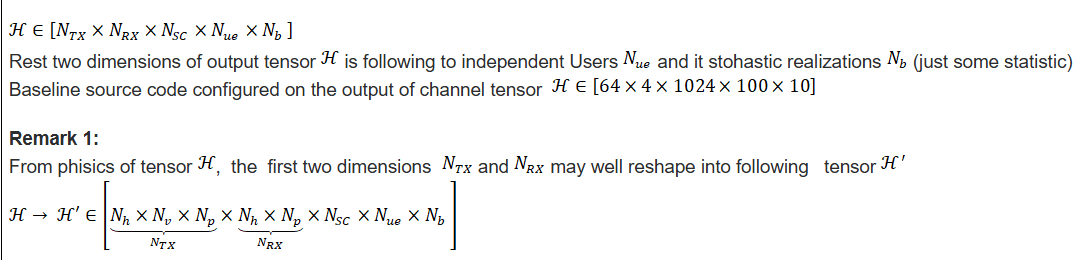

## **Save the channel tensor to '.mat' or '.npy' file**

In [7]:
# from scipy.io import savemat
# savemat(f"Sionna_3GPP_{scenario.upper()}_Channel.mat", {'Hfrq': H_freq})
# from google.colab import files
# files.download(f"Sionna_3GPP_{scenario.upper()}_Channel.mat") # uncomment this to download the tensor

N_tx (BS antenna number) - Количество антенн на Базовой Станции, 32 после Такера

N_rx (UE antenna number) - Количество антенн на Пользовательском Устройстве, 4

N_subcarriers (Subcarriers number) - Количество поднесущих, 128 после Такера

N_users (UE number) - Количество пользователей, 20

N_batches (batch_size) - Количество батчей, 4

каждое число имеет вид H[i,j,k,l,m] = a + bj = |H| * e^(jφ),где

|H| (амплитуда) - ослабление сигнала на этой поднесущей

φ (фаза) - фазовый сдвиг сигнала

i - какая антенна BS передает

j - какая антенна UE принимает

k - на какой поднесущей частоте

l - для какого пользователя

m - в какой реализации канала

In [8]:
#pip install torchcfm --upgrade


In [9]:
#pip install "scipy==1.10.1"

In [10]:
import scipy, ot
print('SciPy:', scipy.__version__); print('POT:', ot.__version__)

SciPy: 1.10.1
POT: 0.9.0


In [11]:
# SVD-based feature extraction and statistics

import numpy as np
from collections import Counter

try:
    import torch
except ImportError:
    torch = None

TAU_RANK_REL = 1e-3
TAU_DEGEN_REL = 1e-4

N_tx, N_rx, N_sc, N_users, N_batches = H_freq.shape
min_dim = min(N_tx, N_rx)

H_slices = H_freq.transpose(3, 4, 2, 0, 1)

svd_U = np.zeros((N_users, N_batches, N_sc, N_tx, min_dim), dtype=np.complex64)
svd_V = np.zeros((N_users, N_batches, N_sc, N_rx, min_dim), dtype=np.complex64)
svd_S = np.zeros((N_users, N_batches, N_sc, min_dim), dtype=np.float32)
svd_rank = np.zeros((N_users, N_batches, N_sc), dtype=np.int16)

rank_values = []
rank_counter = Counter()
degeneracy_counter = Counter()


def _normalize_pair(u_col, v_col, eps=1e-8):
    u_col = np.asarray(u_col, dtype=np.complex64).copy()
    v_col = np.asarray(v_col, dtype=np.complex64).copy()
    u_norm = np.linalg.norm(u_col)
    if u_norm > eps:
        u_col /= u_norm
    v_norm = np.linalg.norm(v_col)
    if v_norm > eps:
        v_col /= v_norm
    pivot_indices = np.where(np.abs(u_col) > eps)[0]
    pivot_value = None
    if pivot_indices.size:
        pivot_value = u_col[pivot_indices[0]]
    else:
        pivot_indices = np.where(np.abs(v_col) > eps)[0]
        if pivot_indices.size:
            pivot_value = v_col[pivot_indices[0]]
    if pivot_value is not None:
        phase = np.exp(-1j * np.angle(pivot_value))
        u_col *= phase
        v_col *= phase
    return u_col, v_col


for u_idx in range(N_users):
    for b_idx in range(N_batches):
        for sc_idx in range(N_sc):
            mat = H_slices[u_idx, b_idx, sc_idx]
            U, S, Vh = np.linalg.svd(mat, full_matrices=False)
            V = Vh.conj().T

            for col in range(min_dim):
                u_col, v_col = _normalize_pair(U[:, col], V[:, col])
                U[:, col] = u_col
                V[:, col] = v_col

            svd_U[u_idx, b_idx, sc_idx] = U[:, :min_dim].astype(np.complex64)
            svd_V[u_idx, b_idx, sc_idx] = V[:, :min_dim].astype(np.complex64)
            svd_S[u_idx, b_idx, sc_idx] = S.astype(np.float32)

            denom = S[0] if S.size else 0.0
            rel = S / (denom + 1e-12)
            effective_rank = int((rel > TAU_RANK_REL).sum())
            if effective_rank == 0 and S.size:
                effective_rank = 1
            rank_values.append(effective_rank)
            rank_counter[effective_rank] += 1
            svd_rank[u_idx, b_idx, sc_idx] = effective_rank

            groups = []
            if S.size:
                start = 0
                for idx in range(S.size - 1):
                    gap = abs(S[idx] - S[idx + 1])
                    denom_gap = max(abs(S[idx]), 1e-12)
                    if gap / denom_gap > TAU_DEGEN_REL:
                        groups.append(idx - start + 1)
                        start = idx + 1
                groups.append(S.size - start)
            else:
                groups.append(0)
            for g in groups:
                degeneracy_counter[g] += 1

rank_array = np.array(rank_values, dtype=np.int16)
if rank_array.size:
    rank_mode = rank_counter.most_common(1)[0]
    print(f"Total matrices analysed: {rank_array.size}")
    print(f"Rank stats -> min: {rank_array.min()}, max: {rank_array.max()}, mean: {rank_array.mean():.2f}, median: {np.median(rank_array):.2f}")
    print(f"Most common rank: {rank_mode[0]} (count={rank_mode[1]})")
    print("Rank histogram:", {k: rank_counter[k] for k in sorted(rank_counter)})
    print("Degeneracy group size counts:", {k: degeneracy_counter[k] for k in sorted(degeneracy_counter)})
else:
    print("No matrices processed for SVD statistics.")

svd_summary = {
    'tau_rank_rel': TAU_RANK_REL,
    'tau_degen_rel': TAU_DEGEN_REL,
    'rank_hist': dict(rank_counter),
    'degeneracy_hist': dict(degeneracy_counter),
    'rank_array': rank_array,
}

print("Stored SVD factors with shapes:")
print(f"U: {svd_U.shape}, V: {svd_V.shape}, Sigma: {svd_S.shape}")

# Feature construction parameters (adjust K_TRUNC after inspecting the statistics above)
K_TRUNC = min_dim  # placeholder; tune manually as needed
ALLOW_ZERO_PADDING = True  # set to False to require full rank for all samples

num_samples = N_users * N_batches
sequence_length = N_sc
channels_per_mode = 4 * (N_tx + N_rx) + 1

amp_u = np.zeros((num_samples, sequence_length, K_TRUNC, N_tx), dtype=np.float32)
phase_u = np.zeros_like(amp_u)
amp_v = np.zeros((num_samples, sequence_length, K_TRUNC, N_rx), dtype=np.float32)
phase_v = np.zeros_like(amp_v)
sigma_raw = np.zeros((num_samples, sequence_length, K_TRUNC), dtype=np.float32)
sigma_valid = np.zeros_like(sigma_raw, dtype=bool)
sample_short_rank = np.zeros(num_samples, dtype=bool)

for u_idx in range(N_users):
    for b_idx in range(N_batches):
        sample_idx = u_idx * N_batches + b_idx
        for sc_idx in range(N_sc):
            singular_values = svd_S[u_idx, b_idx, sc_idx]
            U_block = svd_U[u_idx, b_idx, sc_idx]
            V_block = svd_V[u_idx, b_idx, sc_idx]
            take = min(K_TRUNC, singular_values.size)
            if take < K_TRUNC:
                sample_short_rank[sample_idx] = True
            if take == 0:
                continue
            amp_u[sample_idx, sc_idx, :take, :] = np.abs(U_block[:, :take].T)
            phase_u[sample_idx, sc_idx, :take, :] = np.angle(U_block[:, :take].T)
            amp_v[sample_idx, sc_idx, :take, :] = np.abs(V_block[:, :take].T)
            phase_v[sample_idx, sc_idx, :take, :] = np.angle(V_block[:, :take].T)
            sigma_raw[sample_idx, sc_idx, :take] = singular_values[:take]
            sigma_valid[sample_idx, sc_idx, :take] = True

if not ALLOW_ZERO_PADDING and sample_short_rank.any():
    missing = int(sample_short_rank.sum())
    raise ValueError(f"K_TRUNC={K_TRUNC} exceeds the minimal rank for {missing} samples; set ALLOW_ZERO_PADDING=True or reduce K_TRUNC.")

sigma_values = sigma_raw[sigma_valid]
if sigma_values.size:
    sigma_mean = float(sigma_values.mean())
    sigma_std = float(sigma_values.std())
else:
    sigma_mean = 0.0
    sigma_std = 1.0
if sigma_std < 1e-12:
    sigma_std = 1.0
sigma_z = np.zeros_like(sigma_raw, dtype=np.float32)
if sigma_values.size:
    sigma_z[sigma_valid] = (sigma_raw[sigma_valid] - sigma_mean) / sigma_std
sigma_padding_token = float((0.0 - sigma_mean) / sigma_std)
sigma_z[~sigma_valid] = sigma_padding_token


def _flatten_feature_block(arr):
    arr = arr.transpose(0, 2, 3, 1)
    batch, modes, features, seq = arr.shape
    return arr.reshape(batch, modes * features, seq)

amp_u_block = _flatten_feature_block(amp_u)
phase_u_block = _flatten_feature_block(phase_u)
amp_v_block = _flatten_feature_block(amp_v)
phase_v_block = _flatten_feature_block(phase_v)
sigma_block = _flatten_feature_block(sigma_z[..., None])

data_features = np.concatenate(
    [amp_u_block, phase_u_block, amp_v_block, phase_v_block, sigma_block],
    axis=1,
).astype(np.float32)

feature_channels = data_features.shape[1]
sequence_length = data_features.shape[2]

padding_fraction = sample_short_rank.sum() / num_samples if num_samples else 0.0
print(f"Constructed feature tensor: samples={num_samples}, channels={feature_channels}, sequence_length={sequence_length}")
print(f"K_TRUNC={K_TRUNC}, zero-padding enabled={ALLOW_ZERO_PADDING}, samples requiring padding={sample_short_rank.sum()} ({padding_fraction:.2%})")
print(f"Singular value normalization: mean={sigma_mean:.4f}, std={sigma_std:.4f}, padding token={sigma_padding_token:.4f}")

svd_feature_metadata = {
    'K_TRUNC': K_TRUNC,
    'ALLOW_ZERO_PADDING': ALLOW_ZERO_PADDING,
    'sigma_mean': sigma_mean,
    'sigma_std': sigma_std,
    'sigma_padding_token': sigma_padding_token,
    'N_tx': N_tx,
    'N_rx': N_rx,
    'N_sc': N_sc,
    'N_users': N_users,
    'N_batches': N_batches,
    'channels_per_mode': channels_per_mode,
    'feature_channels': feature_channels,
    'sequence_length': sequence_length,
    'tau_rank_rel': TAU_RANK_REL,
    'tau_degen_rel': TAU_DEGEN_REL,
    'padding_fraction': padding_fraction,
    'rank_hist': dict(rank_counter),
    'degeneracy_hist': dict(degeneracy_counter),
    'min_rank': int(rank_array.min()) if rank_array.size else 0,
    'max_rank': int(rank_array.max()) if rank_array.size else 0,
    'mean_rank': float(rank_array.mean()) if rank_array.size else 0.0,
    'total_matrices': int(rank_array.size),
}

svd_feature_metadata['svd_summary'] = svd_summary
svd_feature_metadata['samples_requiring_padding'] = sample_short_rank.astype(np.bool_)

feature_block_sizes = {
    'amp_u': N_tx,
    'phase_u': N_tx,
    'amp_v': N_rx,
    'phase_v': N_rx,
    'sigma': 1,
}
svd_feature_metadata['block_sizes'] = feature_block_sizes


def unpack_feature_tensor(feature_tensor, metadata, denormalize_sigma=False):
    if torch is not None and isinstance(feature_tensor, torch.Tensor):
        arr = feature_tensor.detach().cpu().numpy()
    else:
        arr = np.asarray(feature_tensor)
    if arr.ndim != 3:
        raise ValueError(f"Expected feature tensor with 3 dims, got shape {arr.shape}")
    batch, channels, seq = arr.shape
    K = metadata['K_TRUNC']
    sizes = metadata['block_sizes']
    offset = 0

    def _extract(size):
        nonlocal offset
        block = arr[:, offset:offset + K * size, :]
        offset += K * size
        block = block.reshape(batch, K, size, seq).transpose(0, 3, 1, 2)
        return block

    amp_u_local = _extract(sizes['amp_u'])
    phase_u_local = _extract(sizes['phase_u'])
    amp_v_local = _extract(sizes['amp_v'])
    phase_v_local = _extract(sizes['phase_v'])
    sigma_block_local = _extract(sizes['sigma'])[..., 0]

    sigma_z_local = sigma_block_local
    sigma_local = sigma_z_local
    if denormalize_sigma:
        sigma_local = sigma_z_local * metadata['sigma_std'] + metadata['sigma_mean']
        padding_mask = np.isclose(sigma_z_local, metadata['sigma_padding_token'], atol=1e-4)
        sigma_local = np.where(padding_mask, 0.0, sigma_local)
    return {
        'amp_u': amp_u_local.astype(np.float32),
        'phase_u': phase_u_local.astype(np.float32),
        'amp_v': amp_v_local.astype(np.float32),
        'phase_v': phase_v_local.astype(np.float32),
        'sigma_z': sigma_z_local.astype(np.float32),
        'sigma': sigma_local.astype(np.float32) if denormalize_sigma else None,
    }


def features_to_svd_components(feature_tensor, metadata, denormalize_sigma=True, enforce_unit_norm=True):
    components = unpack_feature_tensor(feature_tensor, metadata, denormalize_sigma=denormalize_sigma)
    amp_u_local = components['amp_u']
    phase_u_local = components['phase_u']
    amp_v_local = components['amp_v']
    phase_v_local = components['phase_v']

    U = amp_u_local * np.exp(1j * phase_u_local)
    V = amp_v_local * np.exp(1j * phase_v_local)

    if enforce_unit_norm:
        eps = 1e-8
        U = U / np.maximum(np.linalg.norm(U, axis=-1, keepdims=True), eps)
        V = V / np.maximum(np.linalg.norm(V, axis=-1, keepdims=True), eps)

    if denormalize_sigma:
        sigma = components['sigma']
        if sigma is None:
            raise ValueError("Sigma values are not available; set denormalize_sigma=True in unpack_feature_tensor.")
    else:
        sigma = components['sigma_z']
    return {
        'U': U.astype(np.complex64),
        'V': V.astype(np.complex64),
        'sigma': sigma.astype(np.float32),
    }


def reconstruct_channel_from_features(feature_tensor, metadata):
    comps = features_to_svd_components(feature_tensor, metadata, denormalize_sigma=True, enforce_unit_norm=True)
    U = comps['U']  # [B, seq, K, N_tx]
    V = comps['V']  # [B, seq, K, N_rx]
    sigma = np.clip(comps['sigma'], 0.0, None)  # [B, seq, K]
    H_rec = np.einsum('bskn,bskm,bsk->bnms', U, np.conjugate(V), sigma, optimize=True)
    return H_rec.astype(np.complex64)


def flatten_feature_tensor_for_swd(feature_tensor, max_points=200_000, seed=0):
    if torch is not None and isinstance(feature_tensor, torch.Tensor):
        arr = feature_tensor.detach().cpu().numpy()
    else:
        arr = np.asarray(feature_tensor)
    arr = np.transpose(arr, (0, 2, 1))  # [batch, seq, channels]
    arr = arr.reshape(-1, arr.shape[-1])
    total = arr.shape[0]
    if max_points is not None and total > max_points:
        rng = np.random.default_rng(seed)
        idx = rng.choice(total, size=max_points, replace=False)
        arr = arr[idx]
    return arr.astype(np.float64)

# Release intermediate arrays that are no longer needed
del amp_u, phase_u, amp_v, phase_v, sigma_raw, sigma_valid, sigma_z, sample_short_rank


Total matrices analysed: 102400
Rank stats -> min: 4, max: 4, mean: 4.00, median: 4.00
Most common rank: 4 (count=102400)
Rank histogram: {4: 102400}
Degeneracy group size counts: {1: 409600}
Stored SVD factors with shapes:
U: (20, 20, 256, 64, 4), V: (20, 20, 256, 4, 4), Sigma: (20, 20, 256, 4)
Constructed feature tensor: samples=400, channels=548, sequence_length=256
K_TRUNC=4, zero-padding enabled=True, samples requiring padding=0 (0.00%)
Singular value normalization: mean=7.1520, std=3.5845, padding token=-1.9952


In [12]:
import torch
import torch.nn as nn


class TimeCondConvNet1D(nn.Module):
    def __init__(self, in_channels, base_dim=128, num_layers=4, kernel_size=5):
        super().__init__()
        assert num_layers >= 1, "num_layers must be >= 1"
        self.in_channels = in_channels
        self.base_dim = base_dim
        self.kernel_size = kernel_size
        self.time_embed = nn.Sequential(
            nn.Linear(1, base_dim),
            nn.SiLU(),
            nn.Linear(base_dim, base_dim),
            nn.SiLU(),
        )

        conv_blocks = []
        for layer_idx in range(num_layers):
            in_dim = base_dim if layer_idx > 0 else in_channels + base_dim
            conv_blocks.append(
                nn.Conv1d(
                    in_dim,
                    base_dim,
                    kernel_size,
                    padding=kernel_size // 2,
                )
            )
            conv_blocks.append(nn.GroupNorm(8, base_dim))
            conv_blocks.append(nn.SiLU())
        conv_blocks.append(
            nn.Conv1d(
                base_dim,
                in_channels,
                kernel_size,
                padding=kernel_size // 2,
            )
        )
        self.net = nn.Sequential(*conv_blocks)

    def forward(self, x, t):
        # x: [B, C, L], t: [B] or [B, 1]
        B, _, L = x.shape
        if t.ndim == 1:
            t = t[:, None]
        t_embed = self.time_embed(t).unsqueeze(-1).expand(-1, -1, L)
        x_in = torch.cat([x, t_embed], dim=1)
        return self.net(x_in)


class TimeCondMLP(nn.Module):
    def __init__(self, in_channels, length, hidden_dim=512, num_layers=3):
        super().__init__()
        assert num_layers >= 1, "num_layers must be >= 1"
        self.in_channels = in_channels
        self.length = length
        self.hidden_dim = hidden_dim
        input_dim = in_channels * length

        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
        )

        layers = []
        current_dim = input_dim + hidden_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.SiLU())
            current_dim = hidden_dim
        layers.append(nn.Linear(current_dim, input_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        B, C, L = x.shape
        x_flat = x.view(B, C * L)
        if t.ndim == 1:
            t = t[:, None]
        t_embed = self.time_embed(t)
        x_in = torch.cat([x_flat, t_embed], dim=1)
        out = self.net(x_in)
        return out.view(B, C, L)


DEFAULT_CONV_KWARGS = {'base_dim': 128, 'num_layers': 4, 'kernel_size': 5}
DEFAULT_MLP_KWARGS = {'hidden_dim': 512, 'num_layers': 3}


def build_model(model_type, in_channels, length, conv_kwargs=None, mlp_kwargs=None):
    model_type = model_type.lower()
    conv_params = DEFAULT_CONV_KWARGS.copy()
    if conv_kwargs:
        conv_params.update(conv_kwargs)
    mlp_params = DEFAULT_MLP_KWARGS.copy()
    if mlp_kwargs:
        mlp_params.update(mlp_kwargs)
    if model_type == 'conv1d':
        return TimeCondConvNet1D(in_channels, **conv_params)
    if model_type == 'mlp':
        return TimeCondMLP(in_channels, length, **mlp_params)
    raise ValueError(f"Unsupported model_type='{model_type}'. Use 'conv1d' or 'mlp'.")


In [13]:
# Dataloader

from torch.utils.data import DataLoader, TensorDataset
import torch

data_features_np = data_features.astype(np.float32, copy=False)
data_tensor = torch.from_numpy(data_features_np)

dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

feature_channels = data_tensor.shape[1]
sequence_length = data_tensor.shape[2]

print(f"DataLoader ready with {len(dataloader)} batches; tensor shape={data_tensor.shape}")


DataLoader ready with 50 batches; tensor shape=torch.Size([400, 548, 256])


In [14]:
# SB-CFM training

import torch
import torch.nn as nn
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

MODEL_TYPE = 'conv1d'  # 'conv1d' or 'mlp'
CONV_MODEL_KWARGS = {'base_dim': 128, 'num_layers': 4, 'kernel_size': 5}
MLP_MODEL_KWARGS = {'hidden_dim': 512, 'num_layers': 3}

model = build_model(
    MODEL_TYPE,
    feature_channels,
    sequence_length,
    conv_kwargs=CONV_MODEL_KWARGS,
    mlp_kwargs=MLP_MODEL_KWARGS,
).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

try:
    from torchcfm.conditional_flow_matching import SchrodingerBridgeConditionalFlowMatcher
except Exception:
    from torchcfm.losses import SchrodingerBridgeConditionalFlowMatcher

cfm = SchrodingerBridgeConditionalFlowMatcher(sigma=0.5, ot_method="exact")
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


def _cfm_call_and_reshape(cfm_obj, x0, x1, t):
    """Helper to interface flattened tensors with CFM."""
    B = x1.shape[0]
    x0_flat = x0.view(B, -1)
    x1_flat = x1.view(B, -1)

    try:
        out = cfm_obj.sample_location_and_conditional_flow(x0_flat, x1_flat, t)
    except AttributeError:
        out = cfm_obj(x0_flat, x1_flat, t)

    if isinstance(out, dict):
        xt_flat = out.get("xt", None)
        ut_flat = out.get("ut", None)
        if xt_flat is None or ut_flat is None:
            tensors = [v for v in out.values() if torch.is_tensor(v) and v.dim() == 2 and v.shape[0] == B]
            xt_flat, ut_flat = tensors[0], tensors[1]
    else:
        seq = list(out) if isinstance(out, (tuple, list)) else [out]
        tensors = [v for v in seq if torch.is_tensor(v) and v.dim() == 2 and v.shape[0] == B]
        xt_flat, ut_flat = tensors[0], tensors[1]

    xt = xt_flat.view_as(x1)
    ut = ut_flat.view_as(x1)
    return xt, ut


num_epochs = 10
model.train()
for epoch in range(num_epochs):
    total = 0.0
    for (x1_batch,) in tqdm(dataloader, desc=f"SB-CFM epoch {epoch+1}/{num_epochs}"):
        x1 = x1_batch.to(device)  # [B, C, L]
        x0 = torch.randn_like(x1)
        t = torch.rand(x1.size(0), device=device)

        xt, ut = _cfm_call_and_reshape(cfm, x0, x1, t)
        xt, ut = xt.to(device), ut.to(device)

        pred = model(xt, t)
        loss = nn.functional.mse_loss(pred, ut)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()
        total += loss.item()

    print(f"Epoch {epoch+1}: loss={total/len(dataloader):.6f}")


Device: cuda
Model parameters: 1,047,972


SB-CFM epoch 1/10: 100%|██████████| 50/50 [00:01<00:00, 35.86it/s]


Epoch 1: loss=10.198242


SB-CFM epoch 2/10: 100%|██████████| 50/50 [00:00<00:00, 128.90it/s]


Epoch 2: loss=3.409599


SB-CFM epoch 3/10: 100%|██████████| 50/50 [00:00<00:00, 124.34it/s]


Epoch 3: loss=3.237797


SB-CFM epoch 4/10: 100%|██████████| 50/50 [00:00<00:00, 114.42it/s]


Epoch 4: loss=3.860657


SB-CFM epoch 5/10: 100%|██████████| 50/50 [00:00<00:00, 131.06it/s]


Epoch 5: loss=2.973336


SB-CFM epoch 6/10: 100%|██████████| 50/50 [00:00<00:00, 129.19it/s]


Epoch 6: loss=3.219235


SB-CFM epoch 7/10: 100%|██████████| 50/50 [00:00<00:00, 128.87it/s]


Epoch 7: loss=3.457532


SB-CFM epoch 8/10: 100%|██████████| 50/50 [00:00<00:00, 126.64it/s]


Epoch 8: loss=3.994716


SB-CFM epoch 9/10: 100%|██████████| 50/50 [00:00<00:00, 122.24it/s]


Epoch 9: loss=3.075550


SB-CFM epoch 10/10: 100%|██████████| 50/50 [00:00<00:00, 127.20it/s]

Epoch 10: loss=3.592618


In [15]:
# Sampling SB-SDE & inverse reconstruction utilities

import numpy as np


@torch.no_grad()
def sample_sb_sde(model, num_samples=10, steps=40, shape=(feature_channels, sequence_length),
                  sde_sigma=0.2, schedule="const", device='cpu'):
    """Euler-Maruyama sampler for SB-SDE in feature space."""
    model.eval()
    x = torch.randn((num_samples,) + shape, device=device)
    dt = 1.0 / steps

    def g_of_t(t_scalar):
        if schedule == "const":
            return sde_sigma
        if schedule == "vp":
            return sde_sigma * float(np.cos(0.5 * np.pi * float(t_scalar)))
        return sde_sigma

    for k in range(steps):
        t = torch.full((num_samples,), (k + 0.5) / steps, device=device)
        v = model(x, t)
        g = g_of_t((k + 0.5) / steps)
        noise = torch.randn_like(x)
        x = x + dt * v + (g * np.sqrt(dt)) * noise
    return x  # [N, C, L]


generated_features = sample_sb_sde(
    model,
    num_samples=10,
    steps=4,
    shape=(feature_channels, sequence_length),
    sde_sigma=0.0,
    device=device,
)

orig_feature_subset = data_tensor[:generated_features.shape[0]].to(device)
generated_complex = reconstruct_channel_from_features(generated_features, svd_feature_metadata)
original_complex = reconstruct_channel_from_features(orig_feature_subset, svd_feature_metadata)

generated_features_cpu = generated_features.detach().cpu()
orig_feature_subset_cpu = orig_feature_subset.detach().cpu()

print("Generated feature tensor:", generated_features.shape)
print("Reconstructed complex channel from generated samples:", generated_complex.shape)
print("Reference complex channel tensor:", original_complex.shape)


Generated feature tensor: torch.Size([10, 548, 256])
Reconstructed complex channel from generated samples: (10, 64, 4, 256)
Reference complex channel tensor: (10, 64, 4, 256)


In [16]:
# Metrics in feature space: sliced wasserstein and statistics

import numpy as np
import torch
import ot
from ot.sliced import sliced_wasserstein_distance

orig_features_for_metrics = orig_feature_subset_cpu
gen_features_for_metrics = generated_features_cpu

X = flatten_feature_tensor_for_swd(orig_features_for_metrics, max_points=200000, seed=0)
Y = flatten_feature_tensor_for_swd(gen_features_for_metrics, max_points=200000, seed=1)

swd = sliced_wasserstein_distance(X, Y, n_projections=128, p=1, seed=42)
print(f"Sliced Wasserstein distance (feature space, W1): {swd:.6f}")

real_components = unpack_feature_tensor(orig_features_for_metrics, svd_feature_metadata, denormalize_sigma=True)
gen_components = unpack_feature_tensor(gen_features_for_metrics, svd_feature_metadata, denormalize_sigma=True)


def _print_stats(label, array):
    vals = np.asarray(array).reshape(-1)
    vals = vals[np.isfinite(vals)]
    if vals.size:
        print(f"{label} -> mean={vals.mean():.4f}, std={vals.std():.4f}, min={vals.min():.4f}, max={vals.max():.4f}")
    else:
        print(f"{label} -> no valid entries")


sigma_real = real_components['sigma']
sigma_gen = gen_components['sigma']
sigma_real_masked = sigma_real[sigma_real > 0]
sigma_gen_masked = sigma_gen[sigma_gen > 0]
_print_stats("? (real, denormalized)", sigma_real_masked)
_print_stats("? (generated, denormalized)", sigma_gen_masked)

_print_stats("amp(U) real", real_components['amp_u'])
_print_stats("amp(U) generated", gen_components['amp_u'])
_print_stats("phase(U) real", real_components['phase_u'])
_print_stats("phase(U) generated", gen_components['phase_u'])
_print_stats("amp(V) real", real_components['amp_v'])
_print_stats("amp(V) generated", gen_components['amp_v'])
_print_stats("phase(V) real", real_components['phase_v'])
_print_stats("phase(V) generated", gen_components['phase_v'])


Sliced Wasserstein distance (feature space, W1): 0.212303
? (real, denormalized) -> mean=7.0674, std=3.7486, min=0.9426, max=17.1890
? (generated, denormalized) -> mean=7.7331, std=4.4180, min=0.0016, max=26.8178
amp(U) real -> mean=0.1134, std=0.0526, min=0.0001, max=0.4181
amp(U) generated -> mean=0.1098, std=0.9988, min=-4.7121, max=4.6223
phase(U) real -> mean=-0.0204, std=1.7782, min=-3.1416, max=3.1416
phase(U) generated -> mean=-0.0123, std=1.1555, min=-5.4507, max=6.5555
amp(V) real -> mean=0.4632, std=0.1883, min=0.0032, max=0.9733
amp(V) generated -> mean=0.4645, std=1.0025, min=-3.7466, max=4.8922
phase(V) real -> mean=0.0905, std=1.8143, min=-3.1414, max=3.1416
phase(V) generated -> mean=-0.0074, std=1.0613, min=-4.0568, max=4.3531


In [17]:
# Save

import torch

save_path = 'channel_sbcfm_svd_features.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
    'feature_meta': svd_feature_metadata,
    'model_type': MODEL_TYPE,
    'conv_kwargs': CONV_MODEL_KWARGS,
    'mlp_kwargs': MLP_MODEL_KWARGS,
    'svd_summary': svd_summary,
}, save_path)
print("Saved to:", save_path)

ckpt = torch.load(save_path, map_location='cpu')
MODEL_TYPE = ckpt.get('model_type', MODEL_TYPE)
CONV_MODEL_KWARGS = ckpt.get('conv_kwargs', CONV_MODEL_KWARGS)
MLP_MODEL_KWARGS = ckpt.get('mlp_kwargs', MLP_MODEL_KWARGS)
model = build_model(
    MODEL_TYPE,
    feature_channels,
    sequence_length,
    conv_kwargs=CONV_MODEL_KWARGS,
    mlp_kwargs=MLP_MODEL_KWARGS,
).to(device)
model.load_state_dict(ckpt['model_state_dict'])
opt.load_state_dict(ckpt['optimizer_state_dict'])
svd_feature_metadata = ckpt.get('feature_meta', svd_feature_metadata)
svd_summary = ckpt.get('svd_summary', svd_summary)
print("Loaded model, optimizer, and metadata.")


Saved to: channel_sbcfm_svd_features.pth
Loaded model, optimizer, and metadata.


NFE=   1 | sigma std=4.4337 (target 3.5845) | SWD=0.184114
NFE=   2 | sigma std=4.4884 (target 3.5845) | SWD=0.179060
NFE=   3 | sigma std=4.5018 (target 3.5845) | SWD=0.173273
NFE=   5 | sigma std=4.4645 (target 3.5845) | SWD=0.177117
NFE=   7 | sigma std=4.4511 (target 3.5845) | SWD=0.175693
NFE=  10 | sigma std=4.4823 (target 3.5845) | SWD=0.180915
NFE=  20 | sigma std=4.5016 (target 3.5845) | SWD=0.178709
NFE=  40 | sigma std=4.4286 (target 3.5845) | SWD=0.173489


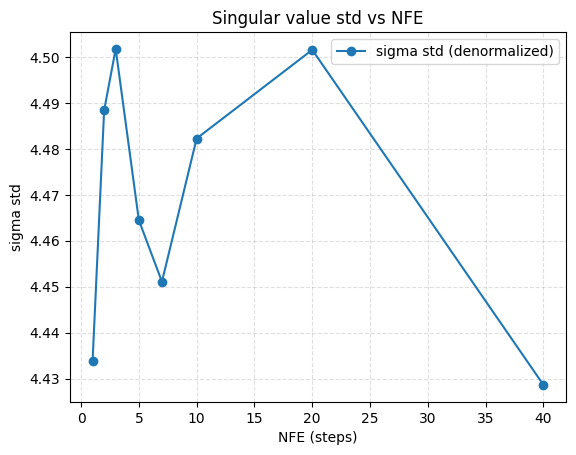

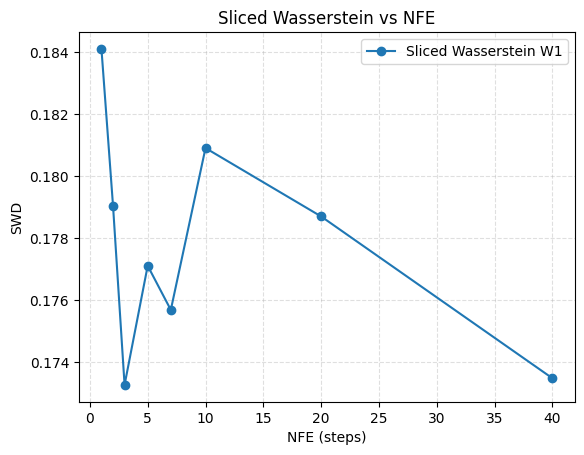

In [18]:
# NFE sweep: sigma std & sliced Wasserstein vs steps

import numpy as np
import torch
import matplotlib.pyplot as plt
from ot.sliced import sliced_wasserstein_distance


def sweep_nfe_and_metrics(
        steps_list=(5, 10, 20, 40, 80, 160),
        num_samples=100,
        shape=(feature_channels, sequence_length),
        sde_sigma=0.0,
        schedule="const",
        device='cpu',
        max_points=200_000,
        n_projections=128,
        flatten_seed_real=0,
        flatten_seed_gen=1,
        verbose=True,
):
    real_flat = flatten_feature_tensor_for_swd(data_tensor, max_points=max_points, seed=flatten_seed_real)
    real_sigma = unpack_feature_tensor(data_tensor, svd_feature_metadata, denormalize_sigma=True)['sigma']
    real_sigma_vals = real_sigma[real_sigma > 0]
    target_sigma_std = float(real_sigma_vals.std()) if real_sigma_vals.size else 0.0

    sigma_stds, swds = [], []
    for steps in steps_list:
        gen_features = sample_sb_sde(
            model,
            num_samples=num_samples,
            steps=steps,
            shape=shape,
            sde_sigma=sde_sigma,
            schedule=schedule,
            device=device,
        ).cpu()

        gen_flat = flatten_feature_tensor_for_swd(gen_features, max_points=max_points, seed=flatten_seed_gen)
        swd = float(sliced_wasserstein_distance(real_flat, gen_flat, n_projections=n_projections, p=1, seed=42))

        gen_sigma = unpack_feature_tensor(gen_features, svd_feature_metadata, denormalize_sigma=True)['sigma']
        gen_sigma_vals = gen_sigma[gen_sigma > 0]
        sigma_std = float(gen_sigma_vals.std()) if gen_sigma_vals.size else 0.0

        sigma_stds.append(sigma_std)
        swds.append(swd)
        if verbose:
            print(f"NFE={steps:4d} | sigma std={sigma_std:.4f} (target {target_sigma_std:.4f}) | SWD={swd:.6f}")

    return np.asarray(steps_list), np.asarray(sigma_stds), np.asarray(swds)


steps_list, sigma_stds, swds = sweep_nfe_and_metrics(
    steps_list=[1, 2, 3, 5, 7, 10, 20, 40],
    num_samples=10,
    shape=(feature_channels, sequence_length),
    sde_sigma=0.0,
    schedule="const",
    device=device,
    max_points=200_000,
    n_projections=128,
    verbose=True,
)

plt.figure()
plt.plot(steps_list, sigma_stds, marker='o', label='sigma std (denormalized)')
plt.xlabel('NFE (steps)')
plt.ylabel('sigma std')
plt.title('Singular value std vs NFE')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

plt.figure()
plt.plot(steps_list, swds, marker='o', label='Sliced Wasserstein W1')
plt.xlabel('NFE (steps)')
plt.ylabel('SWD')
plt.title('Sliced Wasserstein vs NFE')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

plt.show()
